In [61]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [18]:
genres = list(os.listdir('./Data/genres_original/'))
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [2]:
# Discard filename and length as it gives no information
dataset = pd.read_csv('./Data/features_3_sec.csv').iloc[0:, 2:]
dataset

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,8.479527e+05,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,1.170890e+06,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,2.602871e+06,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,4.968878e+05,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


The more data, the better: 9990 instances compared to the 1000 spectrograms. (even if it might seem that 3 sec windows should not model properly the entire genre)

In [3]:
Y = dataset['label']
X = dataset.loc[:, dataset.columns != 'label']

# Normalize X
cols = X.columns
scaler = MinMaxScaler()
scaled_input = scaler.fit_transform(X)
X = pd.DataFrame(scaled_input, columns=cols)

pca = PCA()
principalComponents = pca.fit_transform(X)
principalComponents

array([[-2.42167489e-01, -1.21146568e-01,  7.10578867e-02, ...,
         1.18390705e-03,  9.52651931e-03, -3.28520507e-03],
       [-2.76061511e-01, -2.30291076e-01,  3.89865026e-02, ...,
         9.48647476e-03,  1.70283409e-03, -2.20208787e-03],
       [-1.90024313e-01, -1.19509282e-01,  6.75024037e-02, ...,
        -4.41309670e-04,  4.37235105e-03,  6.74660068e-04],
       ...,
       [-3.90216144e-01,  1.97885066e-01,  2.41838033e-01, ...,
         3.13751676e-02,  6.76318673e-05, -4.70167792e-04],
       [-3.10315416e-01, -3.88161635e-01, -3.05371785e-02, ...,
         2.10508378e-02, -4.78099456e-03, -5.60159539e-04],
       [-3.77906170e-01, -1.06448613e-01,  8.74728597e-02, ...,
         1.38730425e-02, -8.02431982e-03,  6.81585391e-03]])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, Y, random_state=42, stratify=Y, test_size=0.2)
X_train

array([[ 2.76704759e-01,  2.53341184e-01,  1.69727166e-01, ...,
        -7.25610360e-03,  1.72332723e-02,  1.27894556e-03],
       [-7.66803327e-02, -5.65957157e-01, -4.54864618e-02, ...,
         5.77636063e-03,  5.55863473e-04,  4.12496225e-04],
       [ 5.72488937e-01,  4.95094153e-02, -3.47350225e-01, ...,
        -7.41733364e-03, -5.84386485e-03,  5.00470507e-04],
       ...,
       [-3.85289008e-01,  1.41972388e-01,  9.50765902e-02, ...,
        -4.48682840e-05,  5.17358739e-03, -2.50896887e-03],
       [-3.24527679e-01, -1.73609289e-01,  8.29812495e-02, ...,
         8.02360555e-03, -5.04756466e-04,  1.98385419e-03],
       [ 4.31244181e-01, -5.28724927e-02, -3.03363013e-01, ...,
        -7.66138219e-03, -1.36765477e-02, -5.20534759e-03]])

### KNN

In [12]:
pipeline = Pipeline([('knn', KNeighborsClassifier())])

param_grid = {
    'knn__n_neighbors': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Best parameters: {'knn__n_neighbors': 5}
Best score: 0.8867613597672512


In [13]:
model.score(X_test, y_test)

0.8903903903903904

In [27]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

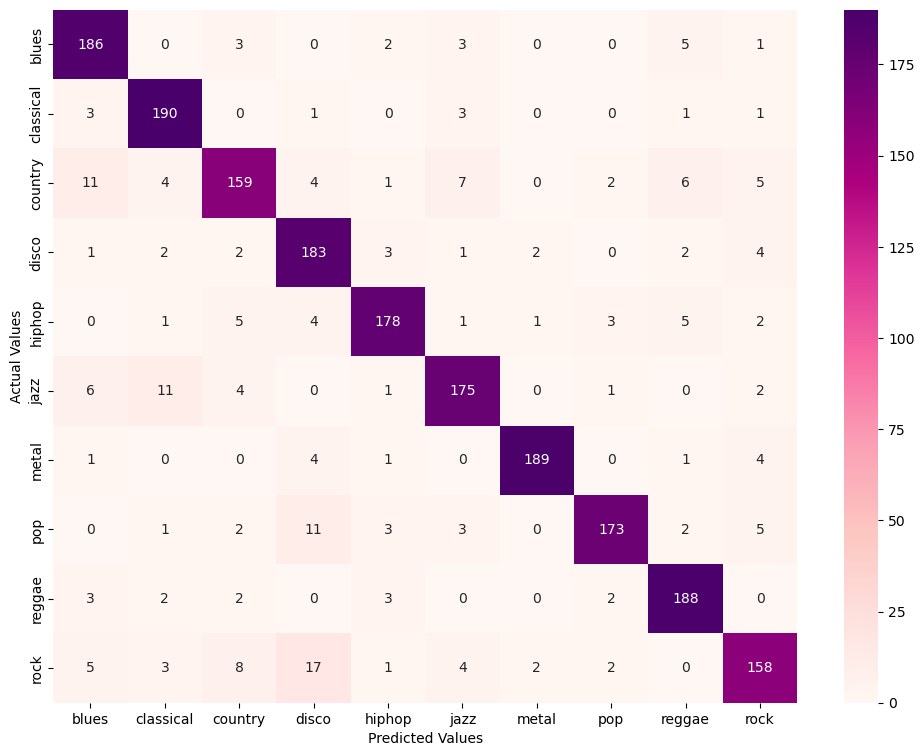

In [34]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/KNN_confusion_matrix.png', bbox_inches='tight')

In [36]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.86      0.93      0.89       200
   classical       0.89      0.95      0.92       199
     country       0.86      0.80      0.83       199
       disco       0.82      0.92      0.86       200
      hiphop       0.92      0.89      0.91       200
        jazz       0.89      0.88      0.88       200
       metal       0.97      0.94      0.96       200
         pop       0.95      0.86      0.90       200
      reggae       0.90      0.94      0.92       200
        rock       0.87      0.79      0.83       200

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



### SVM

In [40]:
pipeline = Pipeline([('svm', SVC())])

param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best score: 0.9076583377752522


In [41]:
model.score(X_test, y_test)

0.9124124124124124

In [42]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

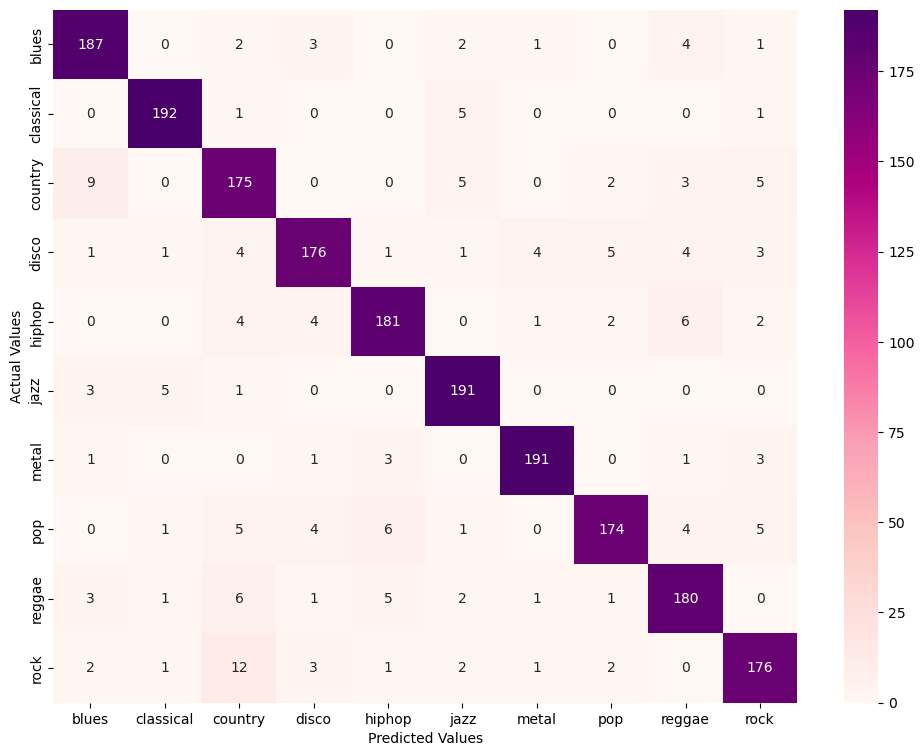

In [43]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/SVM_confusion_matrix.png', bbox_inches='tight')

In [44]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.91      0.94      0.92       200
   classical       0.96      0.96      0.96       199
     country       0.83      0.88      0.86       199
       disco       0.92      0.88      0.90       200
      hiphop       0.92      0.91      0.91       200
        jazz       0.91      0.95      0.93       200
       metal       0.96      0.95      0.96       200
         pop       0.94      0.87      0.90       200
      reggae       0.89      0.90      0.90       200
        rock       0.90      0.88      0.89       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



In [63]:
pipeline = Pipeline([('rf', RandomForestClassifier())])

param_grid = {
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=10)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

model = grid.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 150}
Best score: 0.8507253829638518


In [64]:
model.score(X_test, y_test)

0.8533533533533534

In [65]:
y_pred = model.predict(X_test)
y_pred

array(['country', 'blues', 'classical', ..., 'metal', 'hiphop', 'metal'],
      dtype=object)

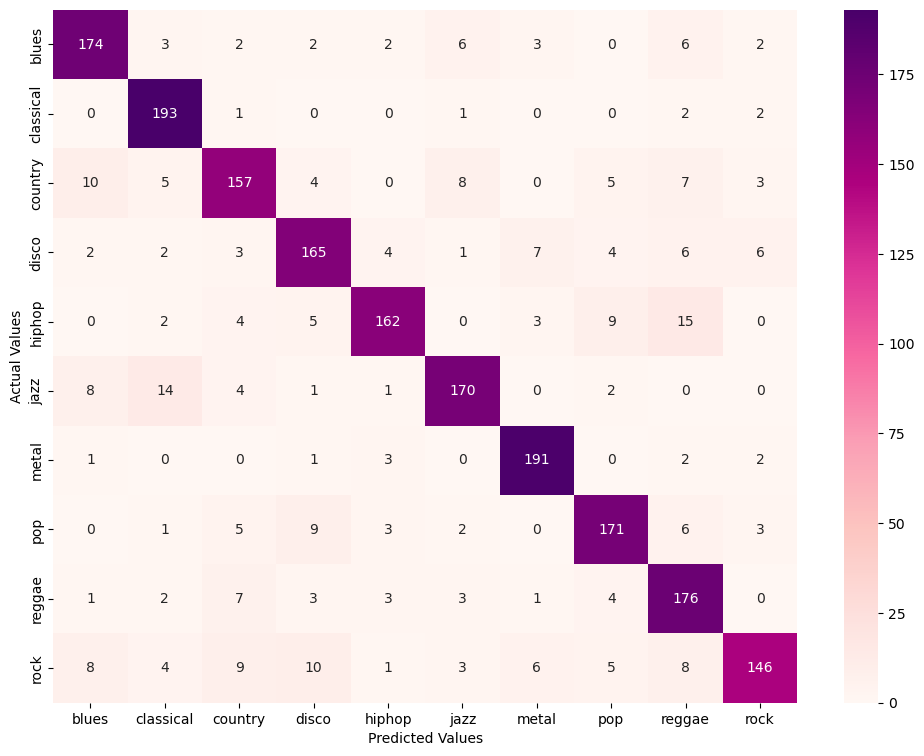

In [66]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                        index=[i for i in genres], 
                        columns=[i for i in genres])
df_cm
plt.figure(figsize=(12, 9))
ax = sn.heatmap(df_cm, annot=True, cmap='RdPu', fmt='g')
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.savefig('./Images/RandomForest_confusion_matrix.png', bbox_inches='tight')

In [67]:
print(classification_report(y_test, y_pred, target_names=genres))

              precision    recall  f1-score   support

       blues       0.85      0.87      0.86       200
   classical       0.85      0.97      0.91       199
     country       0.82      0.79      0.80       199
       disco       0.82      0.82      0.82       200
      hiphop       0.91      0.81      0.85       200
        jazz       0.88      0.85      0.86       200
       metal       0.91      0.95      0.93       200
         pop       0.85      0.85      0.85       200
      reggae       0.77      0.88      0.82       200
        rock       0.89      0.73      0.80       200

    accuracy                           0.85      1998
   macro avg       0.86      0.85      0.85      1998
weighted avg       0.86      0.85      0.85      1998

